In [79]:
import pandas as pd

spy_data = pd.read_csv('SPY.csv', parse_dates=['Date'], index_col='Date')

print(spy_data.head())


                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2010-01-04  112.370003  113.389999  111.510002  113.330002  86.860069   
2010-01-05  113.260002  113.680000  112.849998  113.629997  87.090027   
2010-01-06  113.519997  113.989998  113.430000  113.709999  87.151321   
2010-01-07  113.500000  114.330002  113.180000  114.190002  87.519203   
2010-01-08  113.889999  114.620003  113.660004  114.570000  87.810455   

               Volume  
Date                   
2010-01-04  118944600  
2010-01-05  111579900  
2010-01-06  116074400  
2010-01-07  131091100  
2010-01-08  126402800  


In [92]:
import numpy as np

spy_data['log_returns'] = np.log(spy_data['Adj Close'] / spy_data['Adj Close'].shift(1))

spy_data = spy_data.dropna()

# Rescale the log returns
spy_data['log_returns_scaled'] = 1000 * spy_data['log_returns']


In [93]:
from arch import arch_model

# Fit a GARCH(1,1) model
garch_model = arch_model(spy_data['log_returns_scaled'], vol='Garch', p=1, q=1)
model_results = garch_model.fit(update_freq=10)

print(model_results.summary())

Iteration:     10,   Func. Count:     60,   Neg. LLF: 12910.84048515576
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12910.84048515576
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:     log_returns_scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12910.8
Distribution:                  Normal   AIC:                           25829.7
Method:            Maximum Likelihood   BIC:                           25854.4
                                        No. Observations:                 3602
Date:                Sat, May 11 2024   Df Residuals:                     3601
Time:                        10:38:06   Df Model:                            1
        

In [94]:
# Window size
window_size = 60

total_windows = len(spy_data) - window_size


In [96]:

forecasted_volatility_annualized = []

for i in range(total_windows):
    window_data = spy_data['log_returns_scaled'][i:i + window_size]

    # Fit the GARCH model
    model = arch_model(window_data, vol='Garch', p=1, q=1, mean='Zero')
    model_fit = model.fit(disp='off')


    forecast = model_fit.forecast(horizon=1)
    vol = np.sqrt(forecast.variance.values[-1, :][0])

    vol_rescaled_annualized = (vol / 1000) * np.sqrt(252)
    
    forecasted_volatility_annualized.append(vol_rescaled_annualized)


In [116]:
forecast_dates = spy_data.index[window_size:window_size + total_windows]
forecasted_volatility_series = pd.Series(forecasted_volatility_annualized, index=forecast_dates)


smoothed_volatility = forecasted_volatility_series.rolling(window=10, min_periods=1).mean()

# Calculate the rolling standard deviation (actual volatility)
actual_volatility = spy_data['log_returns_scaled'].rolling(window=10, min_periods=1).std() * np.sqrt(252) / 1000
# Align with the forecasted volatility dates
actual_volatility = actual_volatility[forecast_dates]


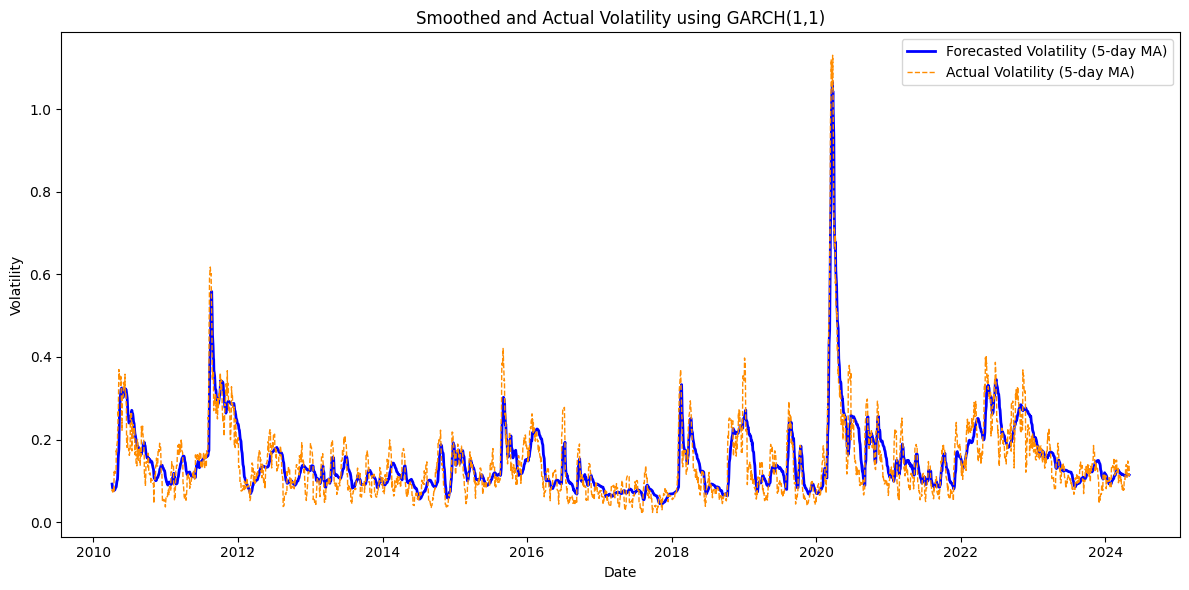

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, smoothed_volatility, color='blue', label='Forecasted Volatility (5-day MA)', linestyle='-', linewidth=2)
plt.plot(forecast_dates, actual_volatility, color='darkorange', label='Actual Volatility (5-day MA)', linestyle='--', linewidth=1)
plt.title('Smoothed and Actual Volatility using GARCH(1,1)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()
